In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
from ray import tune, train
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
from functions.transformers import PolarsColumnTransformer as PCT
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering

In [2]:
data_train_single=pl.read_parquet('data/data_accepted_single_train.parquet')
data_val_single=pl.read_parquet('data/data_accepted_single_val.parquet')
data_train_joint=pl.read_parquet('data/data_accepted_joint_train.parquet')
data_val_joint=pl.read_parquet('data/data_accepted_joint_val.parquet')

In [3]:
data_train_single=dmf.clean_accepted_single(data_train_single)
data_val_single=dmf.clean_accepted_single(data_val_single)
data_train_joint=dmf.clean_accepted_joint(data_train_joint)
data_val_joint=dmf.clean_accepted_joint(data_val_joint)

##### Dropping Features:

In [4]:
data_train_single=dmf.remove_poor_features_single(data_train_single)
data_val_single=dmf.remove_poor_features_single(data_val_single)
data_train_joint=dmf.remove_poor_features_joint(data_train_joint)
data_val_joint=dmf.remove_poor_features_joint(data_val_joint)

### Feature Engineering

In [5]:
data_train_single=feats.date_features(data_train_single,'issue_d')
data_val_single=feats.date_features(data_val_single,'issue_d')
data_train_joint=feats.date_features_joint(data_train_joint,'issue_d')
data_val_joint=feats.date_features_joint(data_val_joint,'issue_d')

In [6]:
data_train_single=dmf.label_target_grades(data_train_single,)
data_val_single=dmf.label_target_grades(data_val_single,)
data_train_joint=dmf.label_target_grades(data_train_joint,)
data_val_joint=dmf.label_target_grades(data_val_joint,)

In [7]:
X_train_single=data_train_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_train_single=data_train_single['grade']

X_val_single=data_val_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_val_single=data_val_single['grade']

X_train_joint=data_train_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_train_joint=data_train_joint['grade']

X_val_joint=data_val_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_val_joint=data_val_joint['grade']


#### Imputers

In [8]:
preprocess_single=Pipeline([])

In [9]:
emp_title_imp = tr.NotInImputerPolars(cat_no=20, fill_value="other")
emp_length_imp = tr.NotInImputerPolars(cat_no=12, fill_value=None)
zip_imp = tr.NotInImputerPolars(cat_no=12, fill_value='other')
imputers = PCT(
    [
        PCT.Step("emp_title", emp_title_imp, "emp_title"),
        PCT.Step("emp_length", emp_length_imp, "emp_length"),
        PCT.Step("zip_code", zip_imp,'zip_code')
    ]
)
preprocess_single.steps.append(("imputers",imputers))

### Encoders

In [10]:
emp_t_enc = tr.TargetMeanOrderedLabeler(how="label")
emp_l_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
emp_l_enc = tr.PolarsOrdinalEncoder(order=emp_l_order)
home_enc = tr.TargetMeanOrderedLabeler(how="label")
verif_enc = tr.TargetMeanOrderedLabeler(how="label")
paymnt_enc = tr.PolarsOneHotEncoder(drop=True)
purpose_enc = tr.TargetMeanOrderedLabeler(how="label")
zip_enc = tr.TargetMeanOrderedLabeler(how="label")
state_enc = tr.TargetMeanOrderedLabeler(how="label")
init_stat_enc = tr.PolarsOneHotEncoder(drop=True)
disbursement_enc = tr.PolarsOneHotEncoder(drop=True)
year_enc = tr.TargetMeanOrderedLabeler(how="last_mean")

encoders = PCT(
    [
        PCT.Step("emp_t_enc", emp_t_enc, "emp_title"),
        PCT.Step("emp_l_enc", emp_l_enc, "emp_length"),
        PCT.Step("home_enc", home_enc, "home_ownership"),
        PCT.Step("verif_enc", verif_enc, "verification_status"),
        PCT.Step("paymnt_enc", paymnt_enc, "pymnt_plan"),
        PCT.Step("purpose_enc", purpose_enc, "purpose"),
        PCT.Step("zip_enc", zip_enc, "zip_code"),
        PCT.Step("state_enc", state_enc, "addr_state"),
        PCT.Step("init_stat_enc", init_stat_enc, "initial_list_status"),
        PCT.Step("disbursement_enc", disbursement_enc, "disbursement_method"),
        PCT.Step("year_enc", year_enc, "year")
    ]
)

preprocess_single.steps.append(("encoders",encoders))
null_imp = tr.PolarsNullImputer(fill_value=-9)
preprocess_single.steps.append(("null_imputer",null_imp))

In [11]:
model_single_lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=6
)

##### Getting lists of selected features based on boruta algorithm with different strictness:

```python
original_columns = preprocess_single.fit_transform(
    X_train_single.sample(10000, seed=1), y_train_single.sample(10000, seed=1)
).columns

boruta_selected_cols = {}

transformed_sample_X = preprocess_single.fit_transform(
    X_train_single.sample(50000, seed=1), y_train_single.sample(50000, seed=1)
)
transformed_sample_y = y_train_single.sample(50000, seed=1)
for perc in np.arange(stop=101, start=10, step=10):
    boruta = tr.BorutaFeatureSelectorPolars(
        model_single_lgbm, random_state=1, perc=perc
    )

    boruta.fit(
        transformed_sample_X,
        transformed_sample_y,
    )
    boruta_selected_cols[perc] = boruta.transform(
        preprocess_single.fit_transform(
            X_train_single.sample(10000, seed=1), y_train_single.sample(10000, seed=1)
        )
    ).columns
    print(f"{perc} calculated")

# Setting the number of threads to 1 to avoid parallelization clash with ray tune.
model_single_lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=1,
)
```

```python
cols_to_drop_space=[]
for key, columns in boruta_selected_cols.items():
    cols_to_drop_space.append([col for col in original_columns if col not in columns])
cols_to_drop_space.insert(0,[])
joblib.dump(cols_to_drop_space,'temp/cols_to_drop.joblib')
```


In [12]:
cols_to_drop_space=joblib.load('temp/cols_to_drop.joblib')

##### Dropper

In [13]:
feature_dropper = tr.FeatureRemover([])
preprocess_single.steps.append(('feature_dropper',feature_dropper))
full_pipeline_single = Pipeline(
    [("preprocess", preprocess_single), ("model", model_single_lgbm)]
)

##### Baseline for tuning:

In [14]:
full_pipeline_single.fit(X_train_single.sample(100000,seed=1),y_train_single.sample(100000,seed=1))
preds=full_pipeline_single.predict(X_val_single)
print(f1_score(y_val_single,preds,average='macro'))

0.3314675878224738


### Search space

In [15]:
models = tunes.Models()
search_space_lgbm = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__num_leaves": tune.randint(10, 1025),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

models.add_model("lgbm_grade_single", full_pipeline_single, search_space_lgbm, metric_threshold=0.35)

### Tree

In [16]:
preprocess_single_dtree = copy.deepcopy(preprocess_single)
model_single_dtree = DecisionTreeClassifier(random_state=1)
full_pipeline_single_dtree = Pipeline(
    [("preprocess", preprocess_single_dtree), ("model", model_single_dtree)]
)

search_space_tree = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
}

models.add_model(
    "tree_grade_single", full_pipeline_single_dtree, search_space_tree, metric_threshold=0.3,override_n=120
)

```python
models.tune_all(
    X_train_single,
    y_train_single,
    X_val_single,
    y_val_single,
    n=240,
    sample_size=25000,
    average="macro",
)
joblib.dump(models, "temp/tuned_grade_models.joblib")
```

In [17]:
models=joblib.load('temp/tuned_grade_models.joblib')

In [18]:
from pprint import pprint
for model in models.models.values():
    pprint (model.name)
    pprint(model.best_params)

'lgbm_grade_single'
{'model__bagging_freq': 5,
 'model__boosting_type': 'gbdt',
 'model__class_weight': 'balanced',
 'model__colsample_bytree': 0.8104455867113739,
 'model__learning_rate': 0.029016364371331177,
 'model__max_bin': 21,
 'model__n_estimators': 94,
 'model__num_leaves': 257,
 'model__reg_alpha': 0.09372004044030545,
 'model__reg_lambda': 1.0859668506115152,
 'model__subsample': 0.9810518830725536,
 'preprocess__feature_dropper__feats_to_drop': ['home_ownership',
                                                'addr_state',
                                                'delinq_2yrs',
                                                'fico_range_high',
                                                'mths_since_last_delinq',
                                                'mths_since_last_record',
                                                'open_acc',
                                                'pub_rec',
                                                'last_fico_ra

In [19]:
for model in models.models.values():
    model.pipeline.fit(X_train_single,y_train_single)

preds_lgbm=models.models['lgbm_grade_single'].pipeline.predict(X_val_single)
preds_dtree=models.models['tree_grade_single'].pipeline.predict(X_val_single)
print(classification_report(y_val_single,preds_lgbm))
print(classification_report(y_val_single,preds_dtree))

              precision    recall  f1-score   support

           1       0.64      0.75      0.69     72529
           2       0.47      0.54      0.50    121365
           3       0.53      0.30      0.39    130148
           4       0.24      0.26      0.25     50567
           5       0.12      0.10      0.11     17982
           6       0.08      0.42      0.13      5509
           7       0.12      0.19      0.14      3054

    accuracy                           0.44    401154
   macro avg       0.31      0.36      0.31    401154
weighted avg       0.47      0.44      0.44    401154

              precision    recall  f1-score   support

           1       0.63      0.62      0.63     72529
           2       0.43      0.53      0.48    121365
           3       0.45      0.48      0.47    130148
           4       0.23      0.12      0.16     50567
           5       0.15      0.11      0.13     17982
           6       0.09      0.04      0.06      5509
           7       0.11 

In [20]:
best_pipeline_single=models.models['lgbm_grade_single'].pipeline

100%|===================| 6995/7000 [08:21<00:00]        

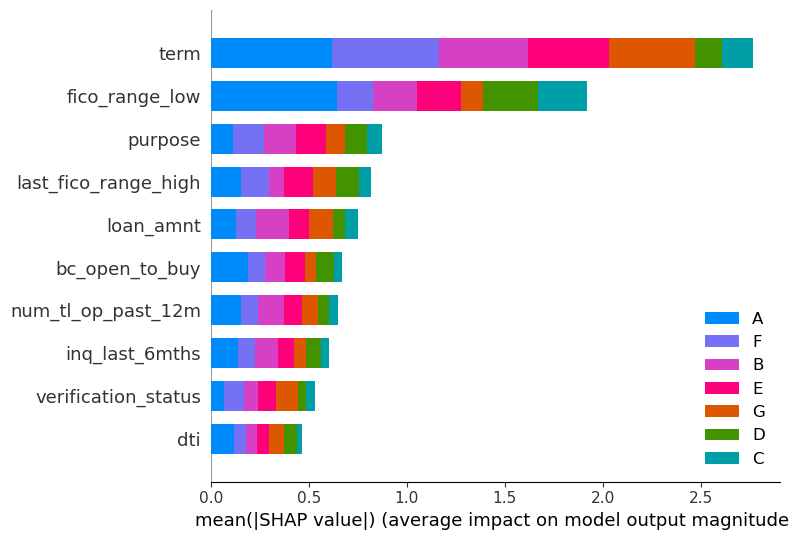

In [21]:
names = models.models['lgbm_grade_single'].pipeline["preprocess"].transform(X_val_single.sample(1000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    models.models['lgbm_grade_single'].pipeline["model"],
    data=models.models['lgbm_grade_single'].pipeline["preprocess"]
    .transform((X_val_single.sample(1000, seed=1)))
    .to_numpy(),
    model_output="raw",
    )

shap_values = explainer_tree.shap_values(
    models.models['lgbm_grade_single'].pipeline["preprocess"].transform(X_val_single.sample(1000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    models.models['lgbm_grade_single'].pipeline["preprocess"].transform(X_val_single.sample(10000, seed=1)).to_numpy(),
    feature_names=names,
    class_names={0:"A", 1:"B",2:"C",3:"D",4:"E",5:"F",6:"G"},
    max_display=10
)

## Joint Applications

##### Setting up joint application preprocessing:

In [23]:
imputers_joint = copy.deepcopy(imputers)
encoders_joint = copy.deepcopy(encoders)
encoders_to_delete = ["disbursement_enc", "paymnt_enc"]

for key in encoders_to_delete:
    del encoders_joint.steps[key]

verif_enc_joint = tr.TargetMeanOrderedLabeler(how="label")

encoders_joint.steps["verif_enc_joint"] = PCT.Step(
    "verif_enc_joint", verif_enc_joint, "verification_status_joint"
)

null_imp_joint = copy.deepcopy(null_imp)
feature_dropper_joint = tr.FeatureRemover([])

preprocess_joint = Pipeline(
    [
        ("imputers", imputers_joint),
        ("encoders", encoders_joint),
        ("null_imputer", null_imp_joint),
        ("feature_dropper", feature_dropper_joint),
    ]
)

model_joint = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=12,
)

full_pipeline_joint = Pipeline(
    [("preprocess", preprocess_joint), ("model", model_joint)]
)

removal space:

```python
original_columns_joint = preprocess_joint.fit_transform(
    X_train_joint.sample(10000, seed=1), y_train_joint.sample(10000, seed=1)
).columns

boruta_selected_cols_joint = {}

transformed_sample_X = preprocess_joint.fit_transform(
    X_train_joint.sample(50000, seed=1), y_train_joint.sample(50000, seed=1)
)
transformed_sample_y = y_train_joint.sample(50000, seed=1)
for perc in np.arange(stop=101, start=10, step=10):
    boruta = tr.BorutaFeatureSelectorPolars(
        model_joint, random_state=1, perc=perc
    )

    boruta.fit(
        transformed_sample_X,
        transformed_sample_y,
    )
    boruta_selected_cols_joint[perc] = boruta.transform(
        preprocess_joint.fit_transform(
            X_train_joint.sample(10000, seed=1), y_train_joint.sample(10000, seed=1)
        )
    ).columns
    print(f"{perc} calculated")

# Setting the number of threads to 1 to avoid parallelization clash with ray tune.
model_joint = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=1,
)
```

```python
cols_to_drop_space_joint=[]
for key, columns in boruta_selected_cols_joint.items():
    cols_to_drop_space_joint.append([col for col in original_columns_joint if col not in columns])
cols_to_drop_space_joint.insert(0,[])
joblib.dump(cols_to_drop_space_joint,'temp/cols_to_drop_joint.joblib')
```

In [26]:
cols_to_drop_space_joint=joblib.load('temp/cols_to_drop_joint.joblib')

In [27]:
search_space_lgbm_joint = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space_joint),
    "model__num_leaves": tune.randint(10, 1025),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

joint_grade_classifier = tunes.Models.Model(
    "joint_grade_lgbm",
    pipeline=full_pipeline_joint,
    param_grid=search_space_lgbm_joint,
    metric_threshold=0.3,
)

joint_grade_classifier.pipeline['model'].set_params(**{'num_threads':1})

LGBMClassifier(class_weight='balanced', force_col_wise=True, num_threads=1,
               objective='multiclass', random_state=1, verbose=-1)

```python
joint_grade_classifier.tune_model(
    X_train_joint,
    y_train_joint,
    X_val_joint,
    y_val_joint,
    n=300,
    sample_size=60000,
    n_training=1,
    average="macro",
)
joblib.dump(joint_grade_classifier, "temp/tuned_joint_grade.joblib")
```

In [28]:
joint_grade_classifier=joblib.load("temp/tuned_joint_grade.joblib")

In [29]:
joint_grade_classifier.best_params

{'preprocess__feature_dropper__feats_to_drop': ['fico_range_high',
  'last_fico_range_low',
  'acc_now_delinq',
  'chargeoff_within_12_mths',
  'num_tl_30dpd',
  'num_tl_90g_dpd_24m',
  'tax_liens',
  'sec_app_fico_range_high',
  'sec_app_chargeoff_within_12_mths'],
 'model__num_leaves': 540,
 'model__n_estimators': 237,
 'model__learning_rate': 0.026171137130242578,
 'model__bagging_freq': 8,
 'model__colsample_bytree': 0.7770020289663396,
 'model__subsample': 0.6108258227385311,
 'model__reg_alpha': 0.01514293570246572,
 'model__reg_lambda': 15.907511756859641,
 'model__boosting_type': 'gbdt',
 'model__class_weight': 'balanced',
 'model__max_bin': 149}

In [31]:
joint_grade_classifier.pipeline['model'].set_params(**{'num_threads':12})
joint_grade_classifier.pipeline.fit(X_train_joint,y_train_joint)
preds_joint_grade=joint_grade_classifier.pipeline.predict(X_val_joint)
print(classification_report(y_val_joint,preds_joint_grade))


              precision    recall  f1-score   support

           1       0.72      0.78      0.75      6153
           2       0.52      0.56      0.54      8269
           3       0.48      0.48      0.48      8318
           4       0.41      0.25      0.31      4926
           5       0.29      0.41      0.34      1511
           6       0.19      0.22      0.20       488
           7       0.11      0.07      0.08       137

    accuracy                           0.52     29802
   macro avg       0.39      0.39      0.39     29802
weighted avg       0.51      0.52      0.51     29802



In [ ]:
stop

100%|===================| 3498/3500 [28:51<00:00]        

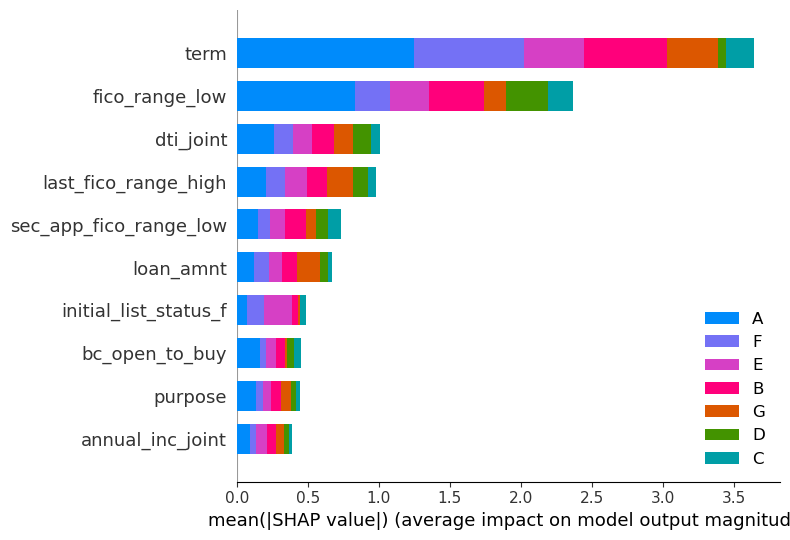

In [32]:
names_joint_grade = (
    joint_grade_classifier.pipeline["preprocess"]
    .transform(X_val_joint.sample(500, seed=1))
    .columns
)
explainer_joint_grade = shap.TreeExplainer(
    joint_grade_classifier.pipeline["model"],
    data=joint_grade_classifier.pipeline["preprocess"]
    .transform((X_val_joint.sample(500, seed=1)))
    .to_numpy(),
    model_output="raw",
)

shap_values_joint_grade = explainer_joint_grade.shap_values(
    joint_grade_classifier.pipeline["preprocess"]
    .transform(X_val_joint.sample(500, seed=1))
    .to_numpy()
)

shap.summary_plot(
    shap_values_joint_grade,
    joint_grade_classifier.pipeline["preprocess"]
    .transform(X_val_joint.sample(10000, seed=1))
    .to_numpy(),
    feature_names=names_joint_grade,
    class_names={0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"},
    max_display=10,
)